<a href="https://colab.research.google.com/github/mugsiemx/deep-learning-challenge/blob/main/Charity_Funding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing

In [1]:
# import the repository for the csv file
! git clone https://github.com/mugsiemx/deep-learning-challenge

Cloning into 'deep-learning-challenge'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 114 (delta 58), reused 25 (delta 8), pack-reused 0
Receiving objects: 100% (114/114), 2.77 MiB | 8.05 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# #  Import and read the charity_data.csv.
# import pandas as pd 
# application_df = pd.read_csv("/Resources/charity_data.csv")
# application_df.head()

# read the CSV file from the Resources folder into a dask DataFrame
## change the data types to strings and integers
%time df = dd.read_csv('/content/deep-learning-challenge/Resources/charity_data.csv', low_memory=False,\
                       dtype={'APPLICATION_TYPE': 'string','AFFILIATION': 'string','CLASSIFICATION': 'string',\
                              'USE_CASE': 'string','ORGANIZATION': 'string','STATUS': 'int','INCOME_AMT': 'string',\
                              'SPECIAL_CONSIDERATIONS': 'string'})
# review the DataFrame
df.dtypes, df.shape

CPU times: user 14.9 ms, sys: 5.09 ms, total: 20 ms
Wall time: 60.5 ms


(EIN                        int64
 NAME                      object
 APPLICATION_TYPE          string
 AFFILIATION               string
 CLASSIFICATION            string
 USE_CASE                  string
 ORGANIZATION              string
 STATUS                     int64
 INCOME_AMT                string
 SPECIAL_CONSIDERATIONS    string
 ASK_AMT                    int64
 IS_SUCCESSFUL              int64
 dtype: object,
 (Delayed('int-52c3ffcb-be23-4487-88af-8b8bc328572f'), 12))

In [3]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
df = df.drop(['EIN','NAME'], axis=1)
# drop other non-productive columns
# df = df.drop(['INCOME_AMT', 'STATUS', 'SPECIAL_CONSIDERATIONS'], axis=1)
df.info(), df.dtypes

<class 'dask.dataframe.core.DataFrame'>
Columns: 10 entries, APPLICATION_TYPE to IS_SUCCESSFUL
dtypes: int64(3), string(7)

(None,
 APPLICATION_TYPE          string
 AFFILIATION               string
 CLASSIFICATION            string
 USE_CASE                  string
 ORGANIZATION              string
 STATUS                     int64
 INCOME_AMT                string
 SPECIAL_CONSIDERATIONS    string
 ASK_AMT                    int64
 IS_SUCCESSFUL              int64
 dtype: object)

In [4]:
# create DataFrame with compute
application_df = df.compute()
application_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


In [5]:
# change Y or N to 1 or 0
# application_df['SPECIAL_CONSIDERATIONS'].unique()
application_df['SPECIAL_CONSIDERATIONS'] = (application_df['SPECIAL_CONSIDERATIONS'] == 'Y').astype(int)

In [6]:
application_df.groupby(['IS_SUCCESSFUL','ASK_AMT'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  ASK_AMT   
0              5000          12095
               5006              2
               5040              1
               5044              1
               5050              1
                             ...  
1              1281905997        1
               1736232349        1
               2310256039        1
               3391919220        1
               8597806340        1
Name: IS_SUCCESSFUL, Length: 8823, dtype: int64

In [7]:
# create bins for ask amount
application_df['ask_amt_bin'] = pd.qcut(application_df['ASK_AMT'], duplicates='drop', q=10)
application_df.groupby(['IS_SUCCESSFUL','ask_amt_bin'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  ask_amt_bin             
0              (4999.999, 30898.8]         12899
               (30898.8, 196546.2]          1462
               (196546.2, 8597806340.0]     1677
1              (4999.999, 30898.8]         14540
               (30898.8, 196546.2]          1968
               (196546.2, 8597806340.0]     1753
Name: IS_SUCCESSFUL, dtype: int64

In [8]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
ask_amt_bin                  3
dtype: int64

In [9]:
# Look at APPLICATION_TYPE value counts for binning
app_counts = application_df['APPLICATION_TYPE'].value_counts()
app_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: Int64

In [10]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`
application_types_to_replace = app_counts[app_counts < 100].index.values
    
# Replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure binning was successful
application_df['APPLICATION_TYPE'].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
T9         156
Other      120
Name: APPLICATION_TYPE, dtype: Int64

In [11]:
# Look at CLASSIFICATION value counts for binning
class_counts = application_df['CLASSIFICATION'].value_counts()
class_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C5200        1
C2600        1
C4200        1
C2190        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: Int64

In [12]:
# You may find it helpful to look at CLASSIFICATION value counts >1
# listed all counts for counts in number of classifications for each classification (1000 is our 'Other' bin point)
c = ((application_df['CLASSIFICATION'].value_counts()).value_counts().sort_values(ascending=False))
c

1        26
2         5
3         3
6         3
32        2
5         2
9         2
10        2
15        2
194       1
104       1
114       1
116       1
1918      1
287       1
777       1
1883      1
75        1
4837      1
95        1
17326     1
58        1
50        1
36        1
6074      1
30        1
20        1
18        1
16        1
14        1
11        1
7         1
34        1
Name: CLASSIFICATION, dtype: Int64

In [13]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`
classifications_to_replace = class_counts[class_counts < 100].index.values

# Replace in dataframe
for cls in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
application_df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
Other      669
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
Name: CLASSIFICATION, dtype: Int64

In [14]:
application_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL,ask_amt_bin
0,T10,Independent,C1000,ProductDev,Association,1,0,0,5000,1,"(4999.999, 30898.8]"
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,0,108590,1,"(30898.8, 196546.2]"
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,0,5000,0,"(4999.999, 30898.8]"
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,0,6692,1,"(4999.999, 30898.8]"
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,0,142590,1,"(30898.8, 196546.2]"
...,...,...,...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,0,0,5000,0,"(4999.999, 30898.8]"
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,0,0,5000,0,"(4999.999, 30898.8]"
34296,T3,CompanySponsored,C2000,Preservation,Association,1,0,0,5000,0,"(4999.999, 30898.8]"
34297,T5,Independent,C3000,ProductDev,Association,1,0,0,5000,1,"(4999.999, 30898.8]"


In [15]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   APPLICATION_TYPE        34299 non-null  string  
 1   AFFILIATION             34299 non-null  string  
 2   CLASSIFICATION          34299 non-null  string  
 3   USE_CASE                34299 non-null  string  
 4   ORGANIZATION            34299 non-null  string  
 5   STATUS                  34299 non-null  int64   
 6   INCOME_AMT              34299 non-null  string  
 7   SPECIAL_CONSIDERATIONS  34299 non-null  int64   
 8   ASK_AMT                 34299 non-null  int64   
 9   IS_SUCCESSFUL           34299 non-null  int64   
 10  ask_amt_bin             34299 non-null  category
dtypes: category(1), int64(4), string(6)
memory usage: 2.6 MB


In [16]:
df = application_df.copy()

amount_max = max(df['ASK_AMT'])
amount_max

8597806340

In [17]:
# listed all counts for counts in number of a for each classification (1000 is our 'Other' bin point)
df_ask = ((application_df['ASK_AMT'].value_counts()).value_counts().sort_values(ascending=False))
df_ask

1        8595
2         147
3           4
25398       1
Name: ASK_AMT, dtype: int64

In [18]:
# Convert categorical data to numeric with `pd.get_dummies`
clean_df = pd.get_dummies(application_df)
clean_df

,STATUS,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,...,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,"ask_amt_bin_(4999.999, 30898.8]","ask_amt_bin_(30898.8, 196546.2]","ask_amt_bin_(196546.2, 8597806340.0]"
0,1,0,5000,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,108590,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,5000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,1,0,6692,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
4,1,0,142590,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34294,1,0,5000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
34295,1,0,5000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
34296,1,0,5000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
34297,1,0,5000,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [19]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 53 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   STATUS                                34299 non-null  int64
 1   SPECIAL_CONSIDERATIONS                34299 non-null  int64
 2   ASK_AMT                               34299 non-null  int64
 3   IS_SUCCESSFUL                         34299 non-null  int64
 4   APPLICATION_TYPE_Other                34299 non-null  uint8
 5   APPLICATION_TYPE_T10                  34299 non-null  uint8
 6   APPLICATION_TYPE_T19                  34299 non-null  uint8
 7   APPLICATION_TYPE_T3                   34299 non-null  uint8
 8   APPLICATION_TYPE_T4                   34299 non-null  uint8
 9   APPLICATION_TYPE_T5                   34299 non-null  uint8
 10  APPLICATION_TYPE_T6                   34299 non-null  uint8
 11  APPLICATION_TYPE_T7                   342

In [20]:
# Split our preprocessed data into our features and target arrays
y = clean_df.IS_SUCCESSFUL.values
X = clean_df.drop(columns='IS_SUCCESSFUL').values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, stratify=y)

In [21]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Compile, Train and Evaluate the Model

In [22]:
# define variables for quick access to training
number_input_features = len(X_train[0])
activation = 'tanh'
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 16
hidden_nodes_layer3 = 24
batch_size = 50
epochs = 100

adam = tf.keras.optimizers.legacy.Adam(learning_rate=.1, decay=1e-3)
loss = "binary_crossentropy"


In [23]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn = Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation=activation)
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation=activation))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation=activation))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 424       
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compile the model
nn.compile(loss=loss, optimizer=adam, metrics=["accuracy"])
print(nn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 424       
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
# create callback
# Export our model to HDF5 file
filepath_w = 'deep-learning-challenge/checkpoints/AlphabetSoupCharity.weight.{epoch:02d}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath_w,
                                                monitor='val_loss',
                                                verbose=1, 
                                                mode='min',
                                                save_weights_only=True,
                                                period=5)
                                                # save_freq=5*batch_size)
                                                # save_best_only=True)
callbacks=[checkpoint]

In [26]:
# Train the model
history = nn.fit(pd.DataFrame(X_train_scaled).apply(np.asarray), 
                 y_train,
                 batch_size=batch_size, 
                 epochs=epochs, 
                 verbose=0,
                 validation_split=0.2,
                 callbacks=callbacks)  


Epoch 5: saving model to deep-learning-challenge/checkpoints/AlphabetSoupCharity.weight.05.hdf5

Epoch 10: saving model to deep-learning-challenge/checkpoints/AlphabetSoupCharity.weight.10.hdf5

Epoch 15: saving model to deep-learning-challenge/checkpoints/AlphabetSoupCharity.weight.15.hdf5

Epoch 20: saving model to deep-learning-challenge/checkpoints/AlphabetSoupCharity.weight.20.hdf5

Epoch 25: saving model to deep-learning-challenge/checkpoints/AlphabetSoupCharity.weight.25.hdf5

Epoch 30: saving model to deep-learning-challenge/checkpoints/AlphabetSoupCharity.weight.30.hdf5

Epoch 35: saving model to deep-learning-challenge/checkpoints/AlphabetSoupCharity.weight.35.hdf5

Epoch 40: saving model to deep-learning-challenge/checkpoints/AlphabetSoupCharity.weight.40.hdf5

Epoch 45: saving model to deep-learning-challenge/checkpoints/AlphabetSoupCharity.weight.45.hdf5

Epoch 50: saving model to deep-learning-challenge/checkpoints/AlphabetSoupCharity.weight.50.hdf5

Epoch 55: saving mod

In [27]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f'Model Inputs: Features: {number_input_features}')
nl_nodes = f'{hidden_nodes_layer1}-{hidden_nodes_layer2}-{hidden_nodes_layer3}'
print(f'Nodes = {nl_nodes}')
print(f'Batch Size = {batch_size}, Epochs = {epochs}')
print(f'Evaluation:   Loss: {model_loss}, Accuracy: {model_accuracy}')

268/268 - 1s - loss: 0.5596 - accuracy: 0.7236 - 562ms/epoch - 2ms/step
Model Inputs: Features: 52
Nodes = 8-16-24
Batch Size = 50, Epochs = 100
Evaluation:   Loss: 0.5596197247505188, Accuracy: 0.7236151695251465


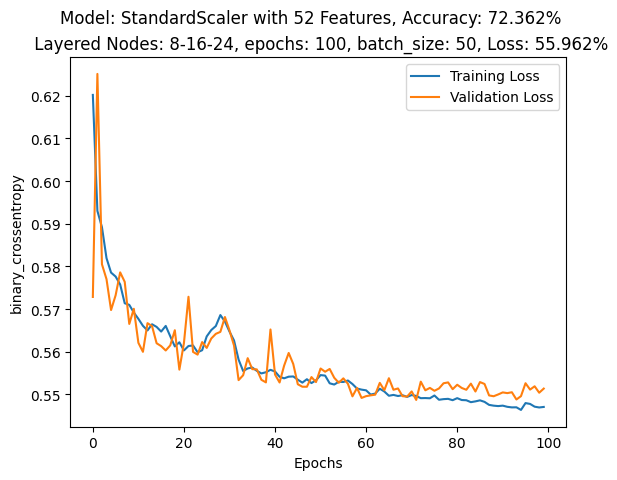

In [28]:
#plot the training history
s_title = f'Model: StandardScaler with {number_input_features} Features, Accuracy: {model_accuracy:.3%}'
n_title = f' Layered Nodes: {nl_nodes}, epochs: {epochs}, batch_size: {batch_size}, Loss: {model_loss:.3%}'

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.suptitle(s_title)
plt.title(n_title)
plt.xlabel('Epochs')
plt.ylabel(loss)
plt.savefig(f'deep-learning-challenge/Images/model_training_history{model_accuracy}.png')
plt.show()

In [29]:
filepath = 'deep-learning-challenge/checkpoints/AlphabetSoupCharity.h5'
tf.keras.saving.save_model(
    nn, filepath, overwrite=True, save_format=None
)

In [30]:
# for documentation copy/paste
print(s_title)
print(n_title)

Model: StandardScaler with 52 Features, Accuracy: 72.362%
 Layered Nodes: 8-16-24, epochs: 100, batch_size: 50, Loss: 55.962%
